In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import seaborn as sns

In [2]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    
seed_everything()

Create Datasets

In [3]:
# Parameters for different timeframes
# - filename
# - input window size
# - output window size

params = {
    "1d" : ("/home/benjamin/Folders_Python/Portfolio/BTC/data/extract/outputBTCUSDT-2021-1-1-2025-11-24-1d.csv", 90, 7), # forecast next 7 days with past 90 days
    "1h" : ("/home/benjamin/Folders_Python/Portfolio/BTC/data/extract/outputBTCUSDT-2021-1-1-2025-11-24-1h.csv", 48, 6), # forecast next 6 hours with past 48 hours (2 days)
    "5m" : ("/home/benjamin/Folders_Python/Portfolio/BTC/data/extract/outputBTCUSDT-2021-1-1-2025-11-24-5m.csv", 2016, 144), # forecast next 12*12*5min (12 hours) with past 7 days * 24 hours * 12 * 5 min
}

In [4]:
# create dicts for data storage
# data is the dictionnary with raw prices
data = {}
# data_logs is the dictionnary with log prices
data_logs = {}
# data_log_diffs is the dictionnary with log price differences (ie log returns)
data_log_diffs = {}

# columns to process
cols = ['Open', 'High', 'Low', 'Close']

for timeframe, (filename, input_window, output_window) in params.items():
    # report out
    print(f"Timeframe: {timeframe}, Filename: {filename}, Input Window: {input_window}, Output Window: {output_window}")
    # load data
    df = pd.read_csv(filename, index_col='Open Time')
    n = len(df)
    # form log prices and their differences
    for c in cols:
        df['log_' + c] = np.log(df[c])
        df['diff_log_' + c] = df['log_'+c].diff()
    df.dropna(inplace=True)
    # create datasets
    X = np.zeros((n - input_window - output_window + 1, input_window))
    Y = np.zeros((n - input_window - output_window + 1, output_window))
    X_logs = np.zeros((n - input_window - output_window + 1, input_window))
    Y_logs = np.zeros((n - input_window - output_window + 1, output_window))
    X_log_diffs = np.zeros((n - input_window - output_window + 1, input_window))
    Y_log_diffs = np.zeros((n - input_window - output_window + 1, output_window))
    for i in range(n-input_window-output_window):
        X[i] = df['Close'].values[i:i+input_window]
        Y[i, :] = df['Close'].values[i+input_window:i+input_window+output_window]
        X_logs[i, :] = df['log_Close'].values[i:i+input_window]
        Y_logs[i, :] = df['log_Close'].values[i+input_window:i+input_window+output_window]
        X_log_diffs[i, :] = df['diff_log_Close'].values[i:i+input_window]
        Y_log_diffs[i, :] = df['diff_log_Close'].values[i+input_window:i+input_window+output_window]
    # store in dicts
    data[timeframe] = (X, Y)
    data_logs[timeframe] = (X_logs, Y_logs)
    data_log_diffs[timeframe] = (X_log_diffs, Y_log_diffs)

Timeframe: 1d, Filename: /home/benjamin/Folders_Python/Portfolio/BTC/data/extract/outputBTCUSDT-2021-1-1-2025-11-24-1d.csv, Input Window: 90, Output Window: 7
Timeframe: 1h, Filename: /home/benjamin/Folders_Python/Portfolio/BTC/data/extract/outputBTCUSDT-2021-1-1-2025-11-24-1h.csv, Input Window: 48, Output Window: 6
Timeframe: 5m, Filename: /home/benjamin/Folders_Python/Portfolio/BTC/data/extract/outputBTCUSDT-2021-1-1-2025-11-24-5m.csv, Input Window: 2016, Output Window: 144


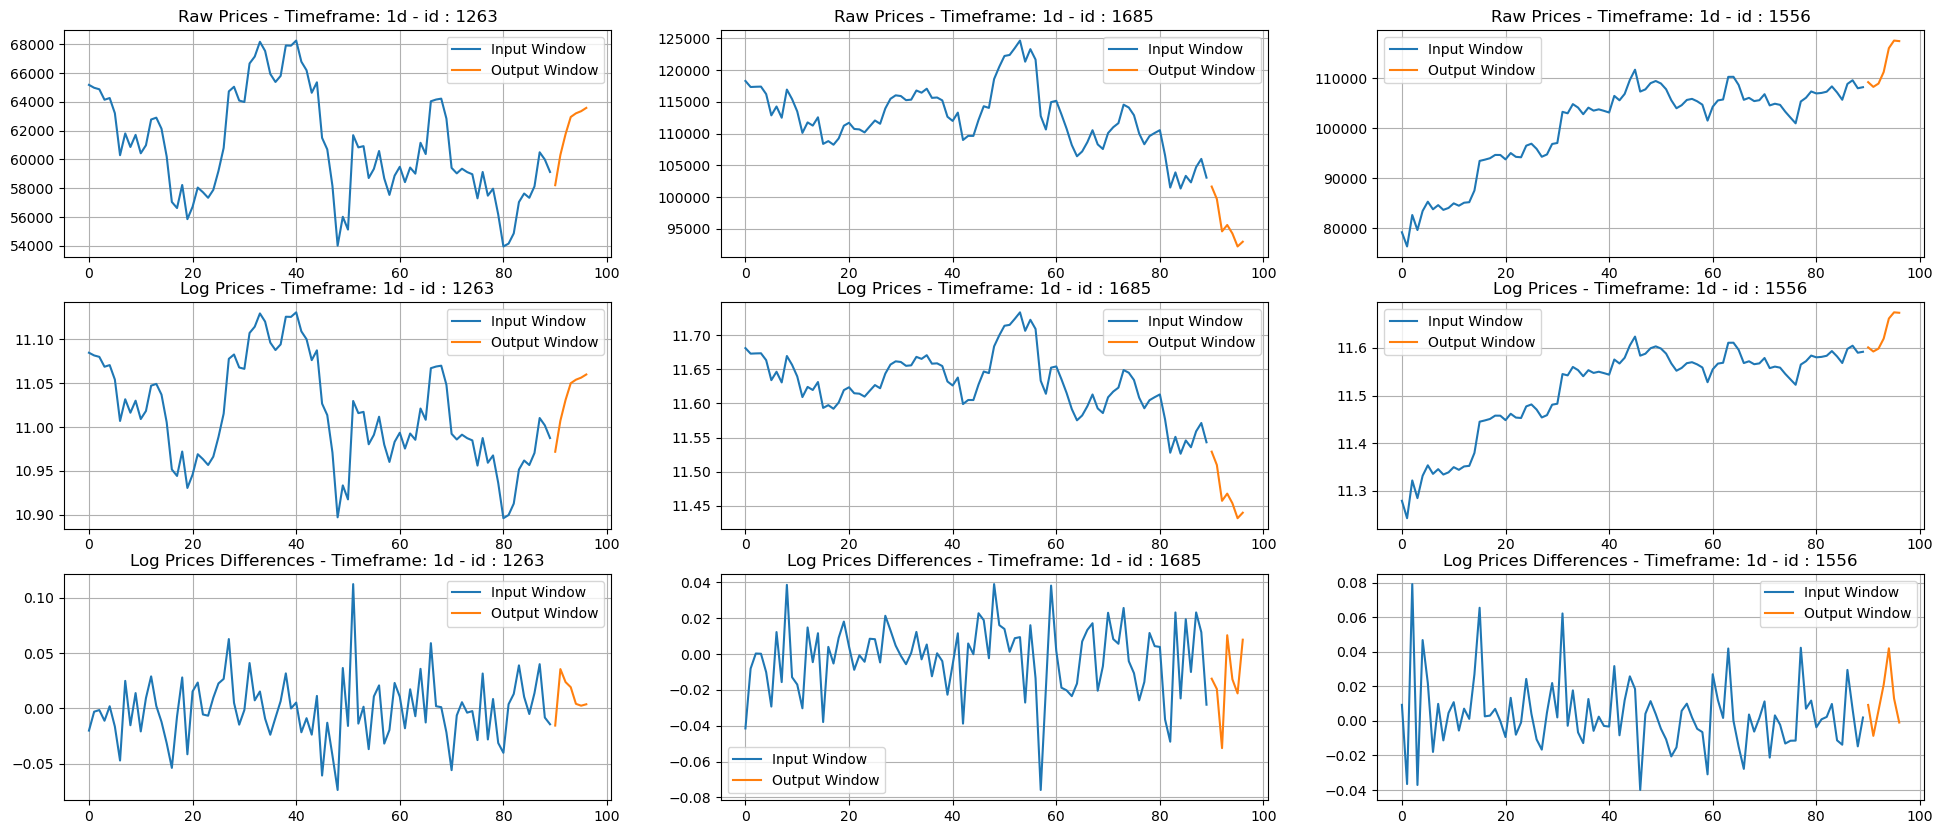

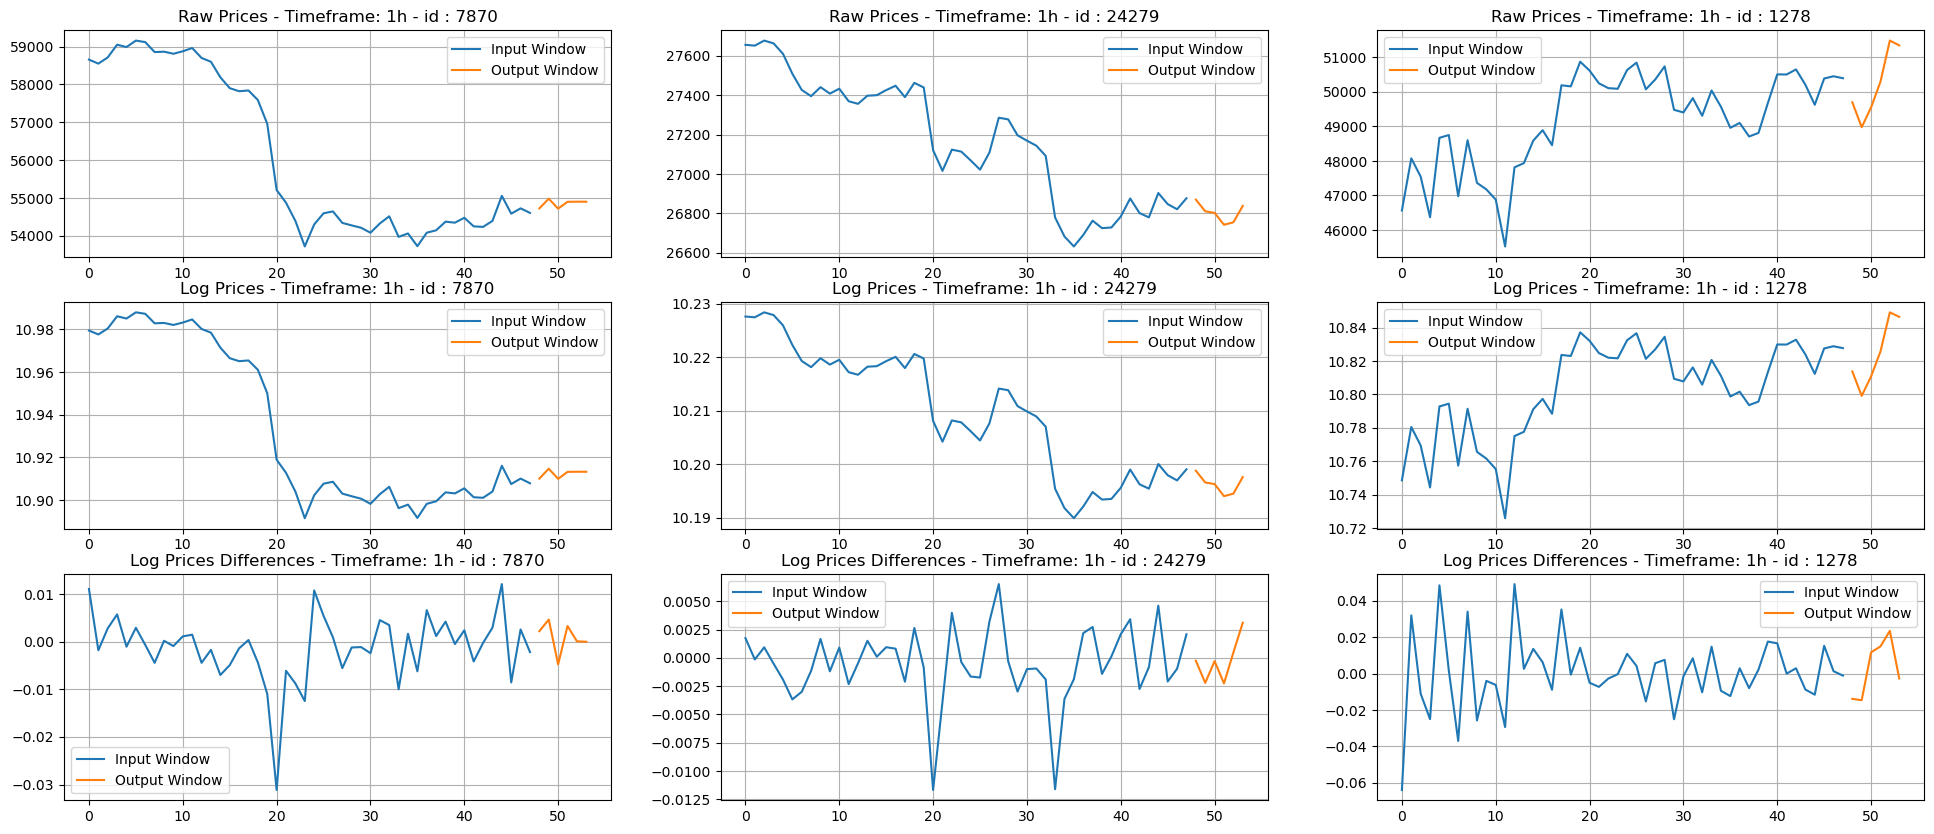

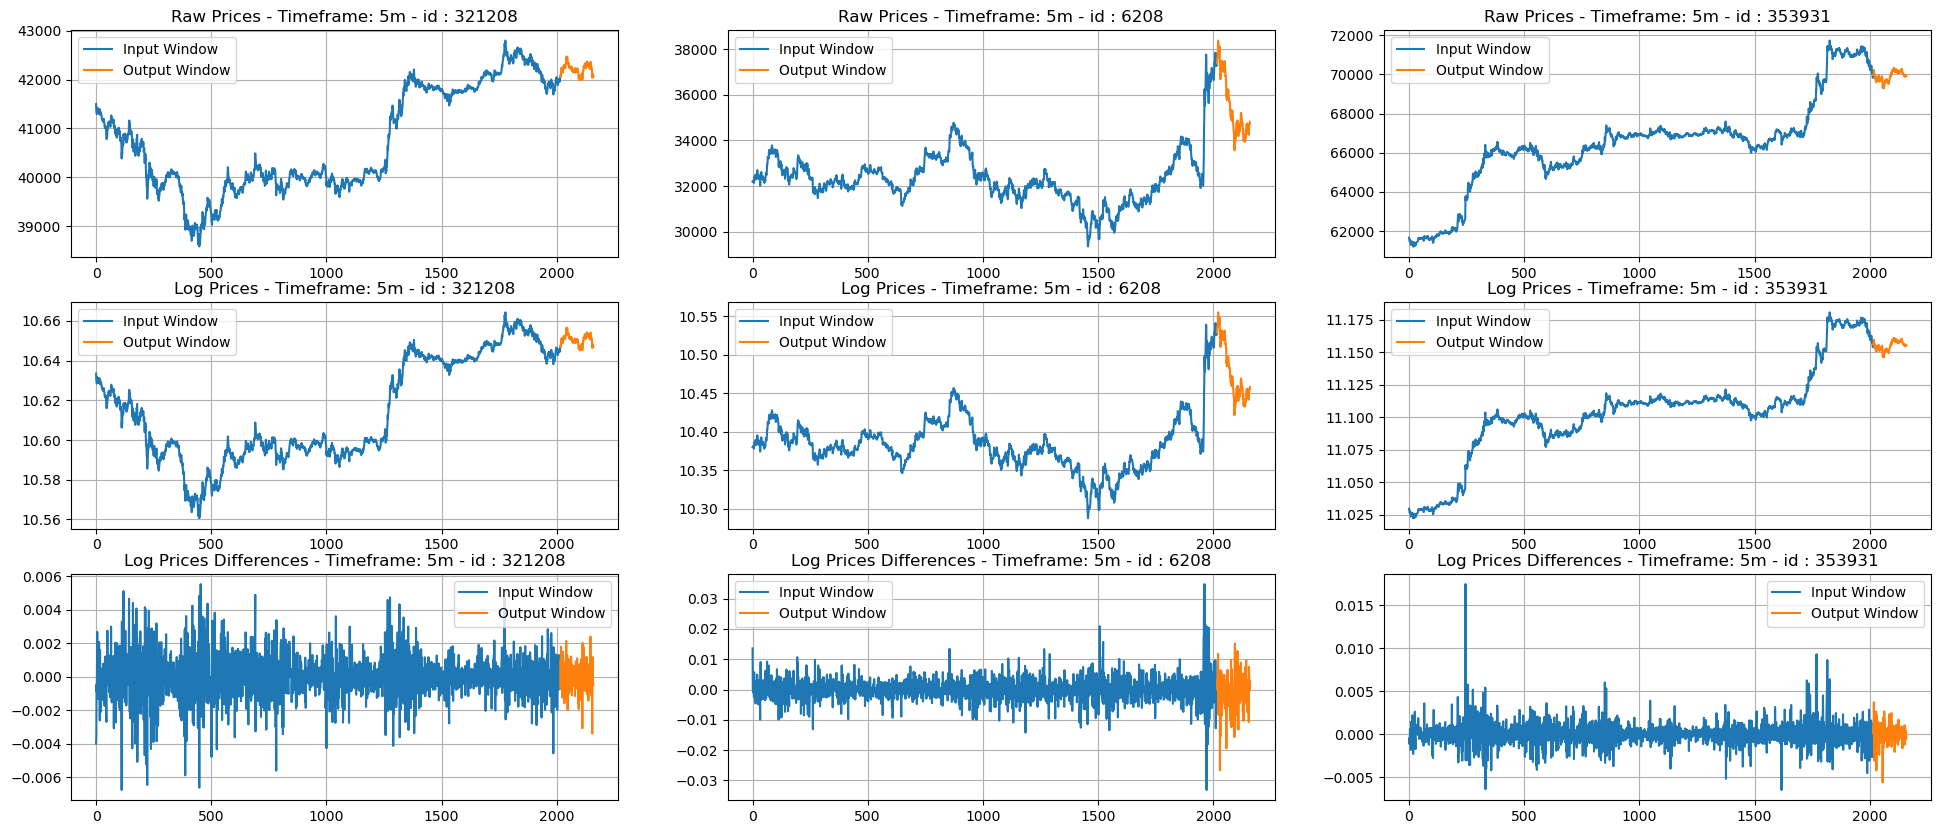

In [5]:
timeframes = ["1d", "1h", "5m"]

for timeframe in timeframes:
    fig, ax = plt.subplots(nrows=3, ncols =3, figsize=(24, 10))
    X, Y = data[timeframe]
    X_logs, Y_logs = data_logs[timeframe]
    X_log_diffs, Y_log_diffs = data_log_diffs[timeframe]

    idx = np.random.choice(len(X), size=3, replace=False)

    for i, id in enumerate(idx):
        # raw prices
        ax[0,i].plot(X[id], label='Input Window')
        ax[0,i].plot(range(len(X[id]), len(X[id]) + len(Y[id])), Y[id], label='Output Window')
        ax[0,i].set_title(f'Raw Prices - Timeframe: {timeframe} - id : {id}')
        ax[0,i].grid()
        ax[0,i].legend()
        # log prices
        ax[1,i].plot(X_logs[id], label='Input Window')
        ax[1,i].plot(range(len(X_logs[id]), len(X_logs[id]) + len(Y_logs[id])), Y_logs[id], label='Output Window')
        ax[1,i].set_title(f'Log Prices - Timeframe: {timeframe} - id : {id}')
        ax[1,i].grid()
        ax[1,i].legend()
        # log diff prices
        ax[2,i].plot(X_log_diffs[id], label='Input Window')
        ax[2,i].plot(range(len(X_log_diffs[id]), len(X_log_diffs[id]) + len(Y_log_diffs[id])), Y_log_diffs[id], label='Output Window')
        ax[2,i].set_title(f'Log Prices Differences - Timeframe: {timeframe} - id : {id}')
        ax[2,i].grid()
        ax[2,i].legend()
        
    plt.show()

# ARIMA on log Prices

### Picking a Log Prices time series at random

In [6]:
# Picking an example time series

timeframe = "1h"  # pick a time frame among "1d", "1h", "5m"
X_logs, Y_logs = data_logs[timeframe]
id = np.random.choice(len(X_logs))

X = X_logs[id]
Y = Y_logs[id]

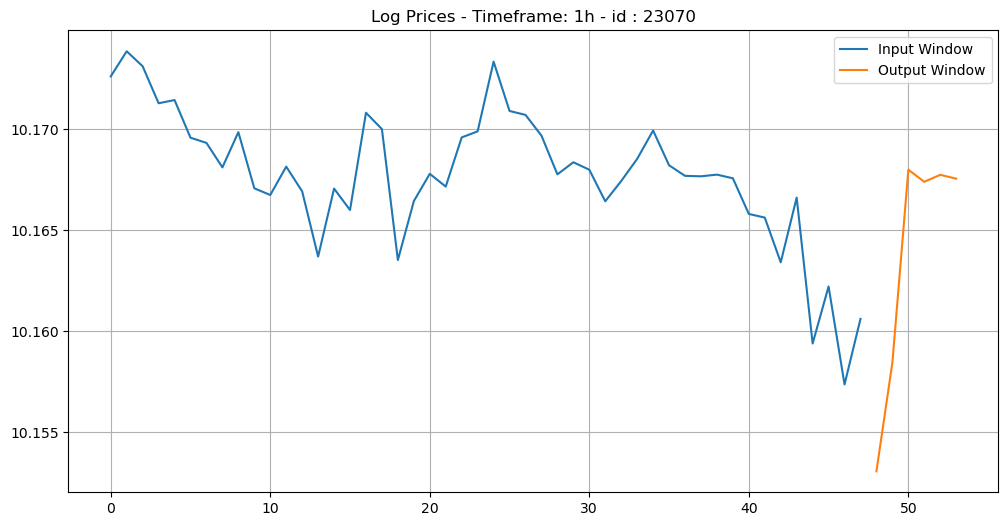

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(X, label='Input Window')
ax.plot(range(len(X), len(X) + len(Y)), Y, label='Output Window')
ax.set_title(f'Log Prices - Timeframe: {timeframe} - id : {id}')
ax.grid()
ax.legend()
plt.show()

### Checking that the Log Prices series is NOT stationary

In [8]:
result = adfuller(X, maxlag=None, regression='c', autolag='AIC')

adf_stat, pvalue, usedlag, nobs, crit_vals, icbest = result

print('ADF Statistic:', adf_stat)
print('p-value:', pvalue)
print('Used lag:', usedlag)
print('Number of obs:', nobs)
print('Critical Values:', crit_vals)
if icbest is not None:
    print('IC best:', icbest)

# optionally format output
out = pd.Series({
    'adf_stat': adf_stat,
    'pvalue': pvalue,
    'usedlag': usedlag,
    'nobs': nobs,
    'icbest': icbest
})
for k, v in crit_vals.items():
    out[f'cv_{k}'] = v
print(out)

ADF Statistic: -1.0848354123257593
p-value: 0.7210813260943801
Used lag: 1
Number of obs: 46
Critical Values: {'1%': np.float64(-3.5812576580093696), '5%': np.float64(-2.9267849124681518), '10%': np.float64(-2.6015409829867675)}
IC best: -339.10596503299143
adf_stat     -1.084835
pvalue        0.721081
usedlag       1.000000
nobs         46.000000
icbest     -339.105965
cv_1%        -3.581258
cv_5%        -2.926785
cv_10%       -2.601541
dtype: float64


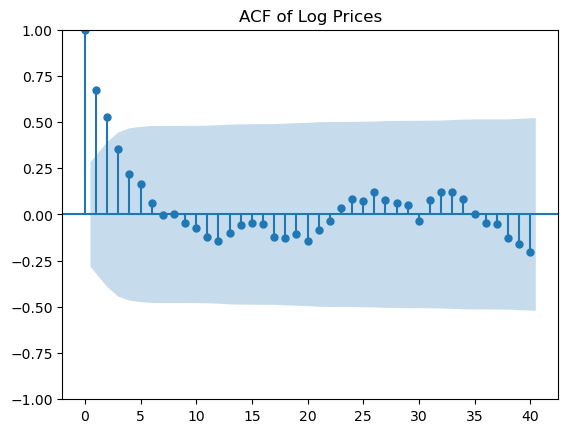

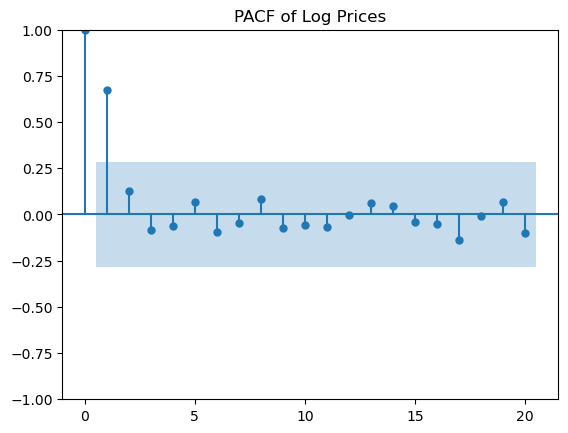

In [9]:
acf_original = plot_acf(X, lags=40, alpha=0.05, title='ACF of Log Prices')
pacf_original = plot_pacf(X, lags=20, alpha=0.05, title='PACF of Log Prices')

### Differenciating and Checking stationarity of log-returns

In [10]:
# Differenciating once
df_X = pd.DataFrame(X, columns=['log_returns'])
diff = df_X.diff().dropna()

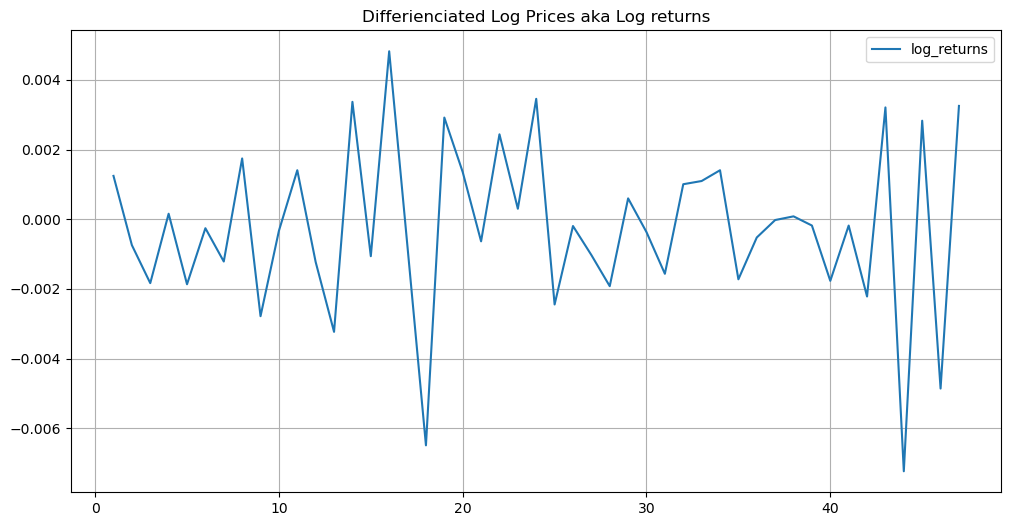

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
diff.plot(ax=ax, title='Differienciated Log Prices aka Log returns')
ax.grid()
plt.show()

In [12]:
series = diff.values.astype(float)   # e.g., log returns
result = adfuller(series, maxlag=None, regression='c', autolag='AIC')

adf_stat, pvalue, usedlag, nobs, crit_vals, icbest = result

print('ADF Statistic:', adf_stat)
print('p-value:', pvalue)
print('Used lag:', usedlag)
print('Number of obs:', nobs)
print('Critical Values:', crit_vals)
if icbest is not None:
    print('IC best:', icbest)

# optionally format output
out = pd.Series({
    'adf_stat': adf_stat,
    'pvalue': pvalue,
    'usedlag': usedlag,
    'nobs': nobs,
    'icbest': icbest
})
for k, v in crit_vals.items():
    out[f'cv_{k}'] = v
print(out)

ADF Statistic: -11.073703131200617
p-value: 4.487074808564639e-20
Used lag: 0
Number of obs: 46
Critical Values: {'1%': np.float64(-3.5812576580093696), '5%': np.float64(-2.9267849124681518), '10%': np.float64(-2.6015409829867675)}
IC best: -330.8569403288246
adf_stat   -1.107370e+01
pvalue      4.487075e-20
usedlag     0.000000e+00
nobs        4.600000e+01
icbest     -3.308569e+02
cv_1%      -3.581258e+00
cv_5%      -2.926785e+00
cv_10%     -2.601541e+00
dtype: float64


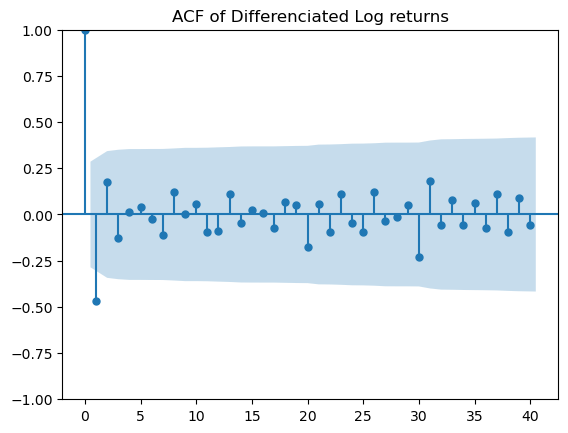

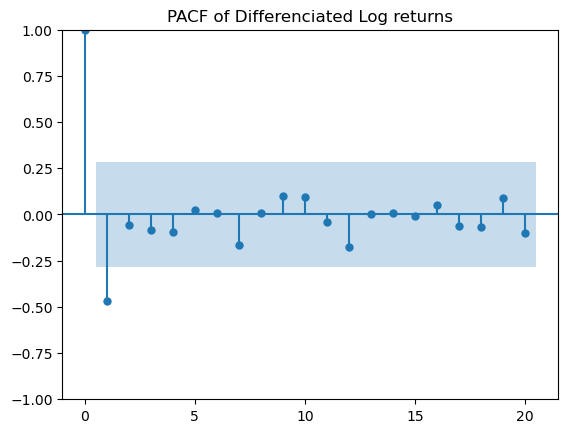

In [13]:
acf_original = plot_acf(diff, lags=40, title='ACF of Differenciated Log returns')
pacf_original = plot_pacf(diff, lags=20, title='PACF of Differenciated Log returns')

### The differenciated log returns appear to be stationary, so we can set d=1 in ARIMA model.

### The PACF plot of the original series suggests p=1

### Parameters : manual choice
- d=1 (differenciating once is enough)
- p=1
- q=1 (why not)

In [14]:
manual_model = ARIMA(X, order=(1,1,1))
manual_model_fit = manual_model.fit()
print(manual_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   48
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 221.705
Date:                Fri, 28 Nov 2025   AIC                           -437.410
Time:                        14:43:44   BIC                           -431.859
Sample:                             0   HQIC                          -435.321
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4989      0.195     -2.559      0.010      -0.881      -0.117
ma.L1          0.0347      0.298      0.116      0.907      -0.550       0.619
sigma2      4.636e-06   8.59e-07      5.394      0.0

### Checking residuals...

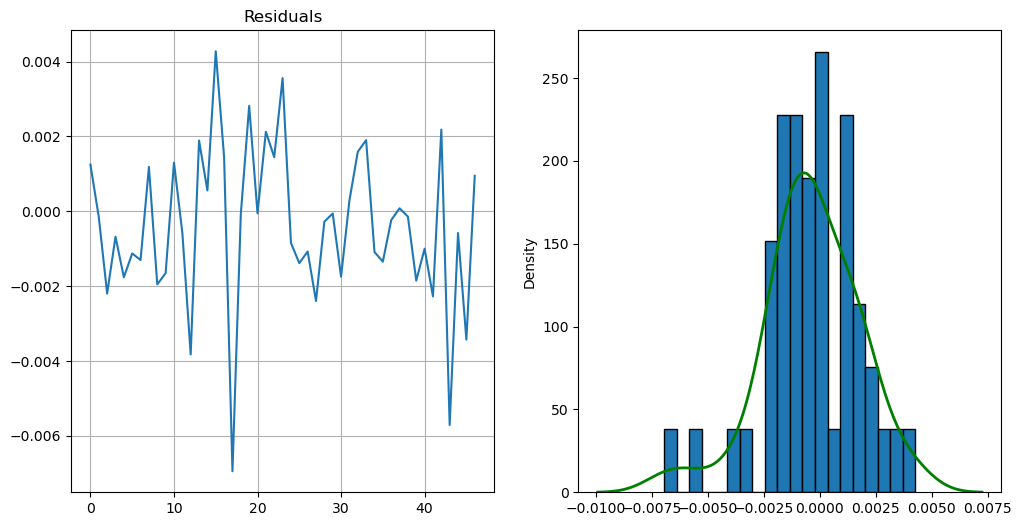

In [15]:
residuals = manual_model_fit.resid[1:]  # skip first NaN value
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].plot(residuals)
ax[0].set_title("Residuals")
ax[0].grid()
ax[1].hist(residuals, bins=20, edgecolor='black', density=True)
sns.kdeplot(residuals, ax=ax[1], color='green', lw=2, fill=False)  # use fill=True, alpha=0.3 to fill
plt.show()

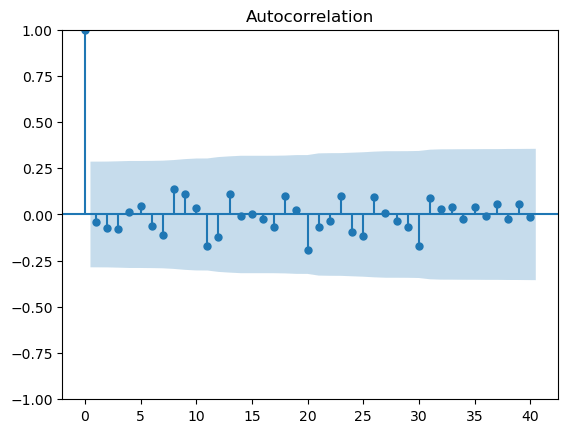

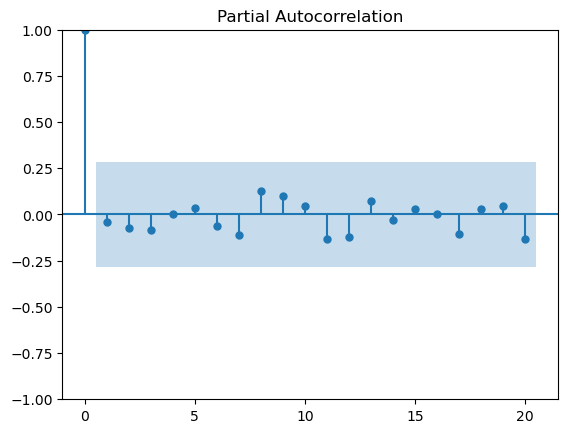

In [16]:
acf_resid = plot_acf(residuals, lags=40)
pacf_resid = plot_pacf(residuals, lags=20)

### Making predictions

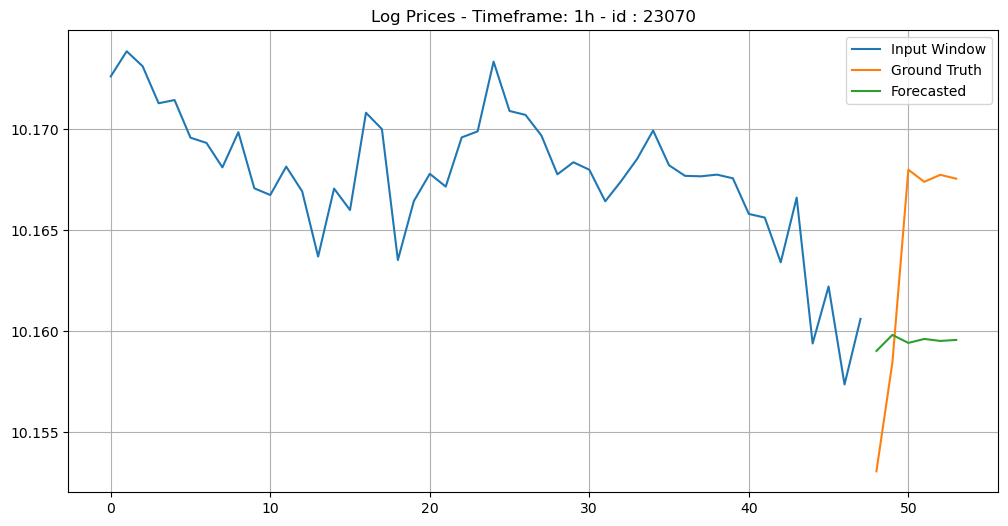

In [17]:
manual_forecast = manual_model_fit.forecast(steps=len(Y))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(X, label='Input Window')
ax.plot(range(len(X), len(X) + len(Y)), Y, label='Ground Truth')
ax.plot(range(len(X), len(X) + len(manual_forecast)), manual_forecast, label='Forecasted')
ax.set_title(f'Log Prices - Timeframe: {timeframe} - id : {id}')
ax.grid()
ax.legend()
plt.show()

### Using AIC criterion to find optimal parameters

In [18]:
import pmdarima as pm
auto_model = pm.auto_arima(X, seasonal=True, stepwise=True)
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 221.710
Date:                Fri, 28 Nov 2025   AIC                           -439.420
Time:                        14:43:45   BIC                           -435.720
Sample:                             0   HQIC                          -438.027
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4654      0.166     -2.806      0.005      -0.790      -0.140
sigma2      4.648e-06   7.55e-07      6.156      0.000    3.17e-06    6.13e-06
Ljung-Box (L1) (Q):                   0.08   Jarque-

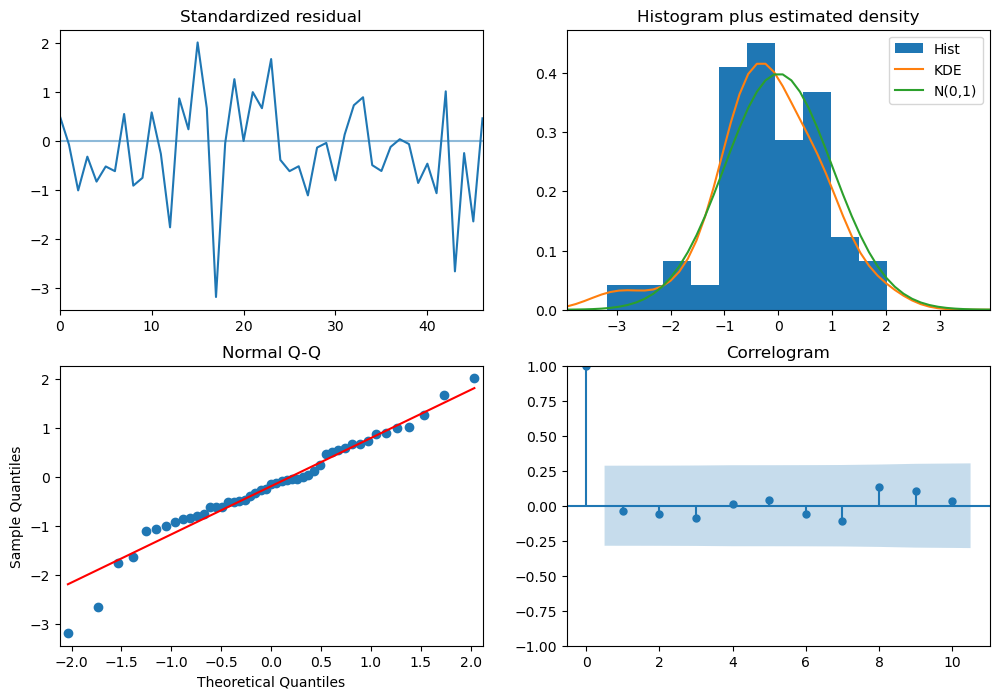

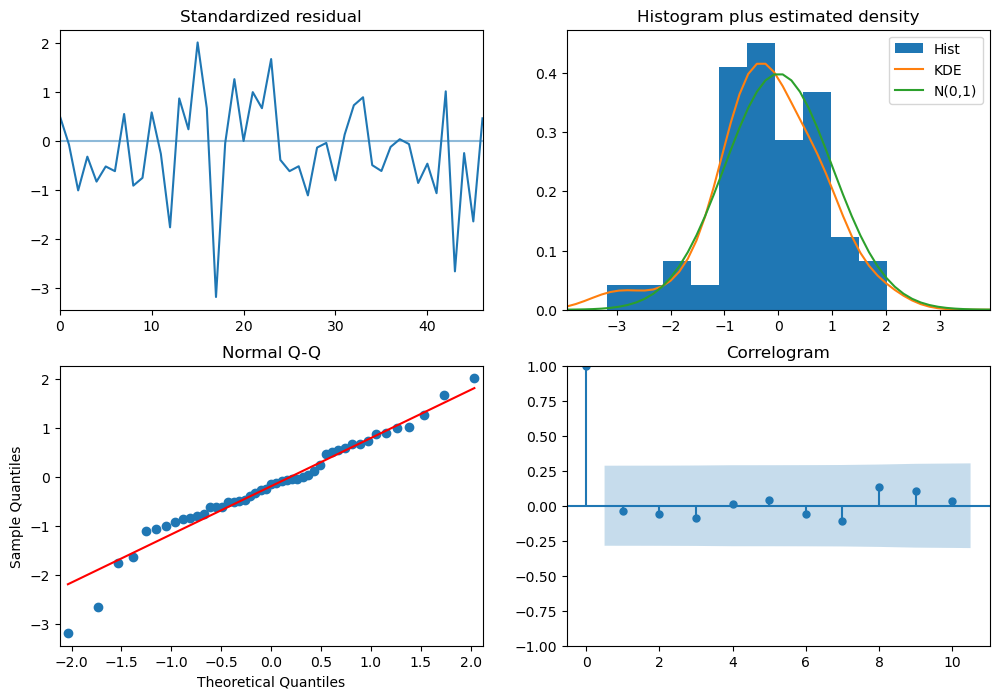

In [19]:
auto_model.plot_diagnostics(figsize=(12,8))

In [23]:
auto_model = ARIMA(X, order=(1,1,0))
auto_model_fit = auto_model.fit()
print(auto_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   48
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 221.710
Date:                Fri, 28 Nov 2025   AIC                           -439.420
Time:                        14:44:35   BIC                           -435.720
Sample:                             0   HQIC                          -438.027
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4654      0.166     -2.806      0.005      -0.790      -0.140
sigma2      4.648e-06   7.55e-07      6.156      0.000    3.17e-06    6.13e-06
Ljung-Box (L1) (Q):                   0.08   Jarque-

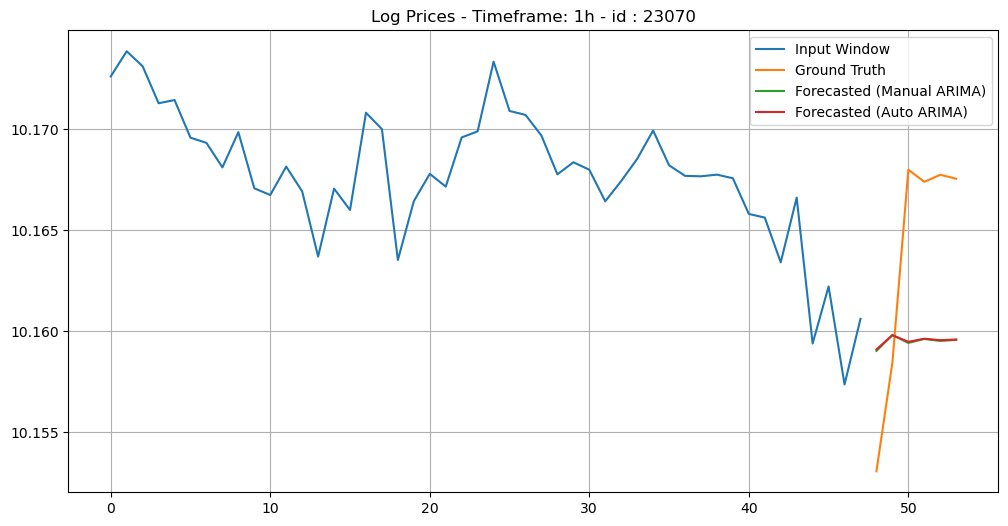

In [24]:
auto_forecast = auto_model_fit.forecast(steps=len(Y))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(X, label='Input Window')
ax.plot(range(len(X), len(X) + len(Y)), Y, label='Ground Truth')
ax.plot(range(len(X), len(X) + len(manual_forecast)), manual_forecast, label='Forecasted (Manual ARIMA)')
ax.plot(range(len(X), len(X) + len(auto_forecast)), auto_forecast, label='Forecasted (Auto ARIMA)')
ax.set_title(f'Log Prices - Timeframe: {timeframe} - id : {id}')
ax.grid()
ax.legend()
plt.show()

### Metrics to compare models

In [25]:
mae = np.mean(np.abs(auto_forecast - Y))
print(f'Mean Absolute Error (Auto ARIMA): {mae:.3e}')
mae_manual = np.mean(np.abs(manual_forecast - Y))
print(f'Mean Absolute Error (Manual ARIMA): {mae_manual:.3e}')

mse = np.mean((auto_forecast - Y)**2)
print(f'Mean Squared Error (Auto ARIMA): {mse:.3e}')
mse_manual = np.mean((manual_forecast - Y)**2)
print(f'Mean Squared Error (Manual ARIMA): {mse_manual:.3e}')

Mean Absolute Error (Auto ARIMA): 6.648e-03
Mean Absolute Error (Manual ARIMA): 6.658e-03
Mean Squared Error (Auto ARIMA): 5.042e-05
Mean Squared Error (Manual ARIMA): 5.062e-05


# The ARIMA model is clearly not enough